In [1]:
import keras
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam

np.random.seed(1)
ticker = "WFC"

# Open the AAPL stock file from the ticker_data dir
TICKER_DIR = "C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\data\\tickers\\ticker_data"
df = pd.read_csv(f"{TICKER_DIR}\\{ticker}.csv", header=0)

print(df.shape)

# Our target is the close price of the stock
target = df["close"].tail(1000)
dataset = df[["high", "low", "open"]].tail(1000)

Using TensorFlow backend.
(1006, 13)


In [2]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i, _ in enumerate(sequences):
		end_ix = i + n_steps
		if end_ix > len(sequences):
			break
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix-1, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

n_steps = 3

high = dataset["high"].values.reshape(len(dataset), 1)
low = dataset["low"].values.reshape(len(dataset), 1)
open = dataset["open"].values.reshape(len(dataset), 1)
close = target.values.reshape(len(dataset), 1)

# stack them horizontally
d = np.hstack((open, high, low, close))
# split sequences
sc = MinMaxScaler()
# d_sc = sc.fit_transform(d)
# X, y = split_sequences(d_sc, n_steps)
X, y = split_sequences(d, n_steps)

n_features = X.shape[2]
print(d.shape)
print(X.shape)
print(y.shape)



(1000, 4)
(998, 3, 4)
(998, 4)


In [3]:
# clears previous sessions
keras.backend.clear_session()
# create a Sequential model, 2 LSTM 100 node layers & 1 fully connected layer
model = Sequential()
model.add(LSTM(100, activation="relu", return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation="relu"))
model.add(Dense(n_features))
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="mae", metrics=["accuracy"])

# split dataset to training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

training_history = model.fit(X_train, y_train, epochs=500, verbose=2)

 - accuracy: 0.8997
Epoch 131/500
 - 0s - loss: 0.2454 - accuracy: 0.8546
Epoch 132/500
 - 0s - loss: 0.2432 - accuracy: 0.8208
Epoch 133/500
 - 0s - loss: 0.2329 - accuracy: 0.9248
Epoch 134/500
 - 0s - loss: 0.2471 - accuracy: 0.9561
Epoch 135/500
 - 0s - loss: 0.2460 - accuracy: 0.9474
Epoch 136/500
 - 0s - loss: 0.2466 - accuracy: 0.9749
Epoch 137/500
 - 0s - loss: 0.2406 - accuracy: 0.9286
Epoch 138/500
 - 0s - loss: 0.3594 - accuracy: 0.7268
Epoch 139/500
 - 0s - loss: 0.3805 - accuracy: 0.8997
Epoch 140/500
 - 0s - loss: 0.2392 - accuracy: 0.9561
Epoch 141/500
 - 0s - loss: 0.2731 - accuracy: 0.9699
Epoch 142/500
 - 0s - loss: 0.2438 - accuracy: 0.9261
Epoch 143/500
 - 0s - loss: 0.2696 - accuracy: 0.8622
Epoch 144/500
 - 0s - loss: 0.2373 - accuracy: 0.9085
Epoch 145/500
 - 0s - loss: 0.2821 - accuracy: 0.9098
Epoch 146/500
 - 0s - loss: 0.2639 - accuracy: 0.8145
Epoch 147/500
 - 0s - loss: 0.2543 - accuracy: 0.7456
Epoch 148/500
 - 0s - loss: 0.3659 - accuracy: 0.8647
Epoch 14

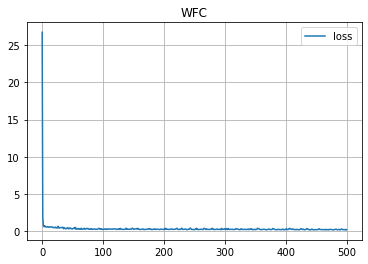

In [4]:
plt.plot(model.history.history["loss"], label="loss")
plt.grid()
plt.legend()
plt.title(ticker)
plt.savefig(f"C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\assets\\losses\\{ticker}.png")

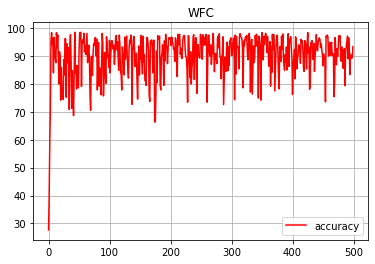

In [5]:
plt.plot(np.array(model.history.history["accuracy"])*100, label="accuracy", color="red")
plt.grid()
plt.legend()
plt.title(ticker)
plt.savefig(f"C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\assets\\accuracies\\{ticker}.png")

In [9]:
np.mean(model.history.history["accuracy"])

0.9006792

In [6]:
# evaluate the model with the testing datasets
scores = model.evaluate(X_test, y_test, verbose=0)
print(*[f"History Item [{item}] reports value of {value}" for value, item in zip(scores, model.metrics_names)], sep="\n")
scores

History Item [loss] reports value of 0.19859882831573486
History Item [accuracy] reports value of 0.9599999785423279


[0.19859882831573486, 0.9599999785423279]

In [7]:
actual = y_test[:, -1]
yhat = model.predict(X_test, verbose=0)
yhat.shape
predictions = yhat[:, -1]

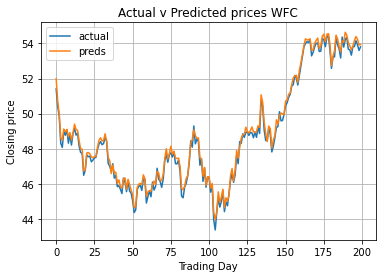

In [8]:
# plot the predicted values against the actual values
fig = plt.figure()
plt.title(f"Actual v Predicted prices {ticker}")
plt.ylabel("Closing price")
plt.xlabel("Trading Day")
plt.plot(actual, label="actual")
plt.plot(predictions, label="preds")
plt.grid()
plt.legend()
plt.savefig(f"C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\assets\\{ticker}.png")